## Example 2D steady-state groundwater flow

In this problem we will examine flow in an 2D aquifer.  Our governing equation is:


$\large K_x\frac{\partial ^2h}{\partial x^2} + K_y\frac{\partial ^2h}{\partial y^2} - W = S\frac{\partial h}{\partial t}$

where K = hydraulic conductivity (km/day), S=Specific Storage, and W = pumping rate (/day)

We will make some simplifying assumptions:

1.  The soil is isotropic: $K_x = K_y = K$
2.  We are only interested in the steady state solution ($\large \frac {\partial h}{\partial t} = 0$)

Hence, our model reduces to:
$\large \frac{\partial ^2h}{\partial x^2} + \frac{\partial ^2h}{\partial y^2} - \frac{W}{K} = 0$


To solve this, we will develop a grid in x and y, and develop a finite difference replacement for our PDE 


Applying finite differences:

$\Large \frac{\partial ^2h}{\partial x^2}= \frac{h_{j,i+1} - 2h_{j,i} + h_{j,i-1}}{\Delta x^2}$

$\Large \frac{\partial ^2h}{\partial y^2}= \frac{h_{j+1,i} - 2h_{j,i} + h_{j-1,i}}{\Delta y^2}$

We will use a regular grid with $\Delta x  = \Delta y$

In that case our full finite difference replacement is:
$\Large \frac{h_{j,i-1}+h_{j,i+1}+h_{j+1,i}+h_{j-1,i}-4h_{j,i}}{\Delta x^2} - \frac{W}{K} = 0$

If we solve this for $h_{j,i}$, we get:

$\Large  h_{j,i} = \frac {(h_{j,i-1}+h_{j,i+1}+h_{j+1,i}+h_{j-1,i})}{4} - \frac {W \Delta x^2} {(4K)}$


Grid dimensions: 41 rows, 81 cols
Well: x=0.3 (12), y=0.6 (24), q=3.0
Well: x=1.2 (48), y=0.3 (12), q=1.5
Converged after 346 iterations


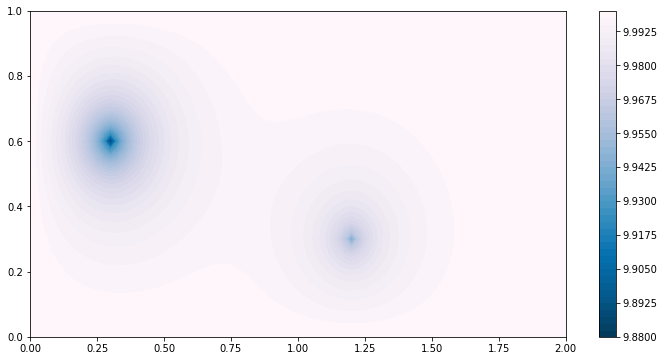

In [5]:
import numpy as np
from matplotlib import colors, ticker, cm
import matplotlib.pyplot as plt

# convert floating point coords to grid indices
def CoordToGrid(x, y, width, height, rows, cols):
    x = int((x / width) * cols)
    y = int((y / height) * rows)
    return x, y

# solve the grid for one pass, returning an updated grid and a measure of improvement
def SolveGrid(h, wells):
    # first, make a new grid the same dmensions as the starting grid - this is so when we start writing
    # updated grid values, we don't overwrite nodes we need in the next calculations
    (rows, cols) = h.shape
    hNew = np.zeros((rows,cols))
    delta = 0

    for j in range(1, rows - 1):  # iterate through y (note starting, ending index)
        for i in range(1, cols - 1):  # iterate through x (note starting index)

            # add wells if necessary
            wq = 0
            for well in wells:
                if i == well[0] and j == well[1]:
                    wq = well[2]

            hNew[j,i] = ((h[j-1,i] + h[j+1,i] + h[j,i-1] + h[j,i+1])/4) - (wq*dx*dx/(4*K))
            delta += hNew[j,i] - h[j,i]

    hNew[:,0]  = 10  # hNew[:,1]      # apply left hand  boundary condition
    hNew[:,-1] = 10  # hNew[:,-2]     # apply right hand boundary condition
    hNew[0,:]  = 10  # hNew[1,:]      # apply bottom boundary condition
    hNew[-1,:] = 10  # hNew[-2,:]     # apply top boundary condition

    delta = delta / (rows*cols)   # normalize to delta per grid node
    return hNew, delta


############################################################
# Main Program
############################################################

width = 2  # units - km
height = 1  # units - km
dx = 0.025   # units - km
K = 0.0106  # units - km/day

# get grid dimensions.  Note: we assume that x extends horizontally, y extends vertically on the grid
xdistances = np.arange(0, width + dx / 2, dx)
ydistances = np.arange(0, height + dx / 2, dx)
cols = len(xdistances)
rows = len(ydistances)

print("Grid dimensions: {} rows, {} cols".format(rows, cols))

# make a grid to contain state values through space and time
# and set initial conditions - entire grid is a a fixed value
h = np.full((rows, cols), 10, dtype=np.float)

# define wells to use
wells = [[0.3, 0.6, 3.0],
         [1.2, 0.3, 1.5] ]

for well in wells:  # convert well coordinants to grid points
    iWell, jWell = CoordToGrid(well[0], well[1], width, height, rows, cols)
    print("Well: x={:.2} ({}), y={:.2} ({}), q={:.3}".format(well[0], iWell, well[1], jWell, well[2]))
    well[0] = iWell
    well[1] = jWell

delta = 100000  # delta tracks the grid values en route to convergence
iters = 0
while np.abs(delta) > 0.00001:
    h, delta = SolveGrid(h, wells)
    iters += 1

print("Converged after {} iterations".format(iters))
X, Y = np.meshgrid(xdistances, ydistances)

# Automatic selection of levels works; setting the
# log locator tells contourf to use a log scale:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
cs = ax.contourf(X, Y, h, 50, cmap=cm.PuBu_r)

cbar = fig.colorbar(cs)

plt.show()